In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Generate dataset

In [ ]:
y = np.random.randint(0,7,2100)
idx= []
for i in range(7):
    print(i,sum(y==i))
    idx.append(y==i)

0 297
1 295
2 282
3 313
4 303
5 318
6 292


In [ ]:
x1 = np.zeros((2100,2))
x = np.zeros((2100,8))

In [ ]:

con_data = 0.0015*np.eye(6)



d1 = np.tile(con_data[:,0],(sum(idx[0]),1))
x1[idx[0],:] = np.random.uniform(low=[1,8],high=[2,7],size=(sum(idx[0]),2))
x[idx[0],:] = np.concatenate((x1[idx[0],:],d1),axis=1)


d2 = np.tile(con_data[:,1],(sum(idx[1]),1))
x1[idx[1],:] = np.random.uniform(low=[1,5],high=[2,6],size=(sum(idx[1]),2))
x[idx[1],:] = np.concatenate((x1[idx[1],:],d2),axis=1)

d3 = np.tile(con_data[:,2],(sum(idx[2]),1))
x1[idx[2],:] = np.random.uniform(low=[1,3],high=[2,4],size=(sum(idx[2]),2))
x[idx[2],:] = np.concatenate((x1[idx[2],:],d3),axis=1)

d4 = np.tile(con_data[:,3],(sum(idx[3]),1))
x1[idx[3],:] = np.random.uniform(low=[1,1],high=[2,2],size=(sum(idx[3]),2))
x[idx[3],:] = np.concatenate((x1[idx[3],:],d4),axis=1)


d5 = np.tile(con_data[:,4],(sum(idx[4]),1))
x1[idx[4],:] = np.random.uniform(low=[1,-1],high=[2,0],size=(sum(idx[4]),2))
x[idx[4],:] = np.concatenate((x1[idx[4],:],d5),axis=1)



d6 = np.tile(con_data[:,5],(sum(idx[5]),1))
x1[idx[5],:] = np.random.uniform(low=[1,-2],high=[2,-3],size=(sum(idx[5]),2))
x[idx[5],:] = np.concatenate((x1[idx[5],:],d6),axis=1)


d7 = np.tile(np.zeros(6),(sum(idx[6]),1))
x1[idx[6],:] = np.random.uniform(low=[2.75,0],high=[3.75,3],size=(sum(idx[6]),2))
x[idx[6],:] = np.concatenate((x1[idx[6],:],d7),axis=1)



In [ ]:
x[idx[0],:][0],x[idx[1],:][0],x[idx[2],:][0],x[idx[3],:][0],x[idx[4],:][0],x[idx[5],:][0]

(array([1.75755355e+00, 7.66953726e+00, 1.50000000e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([1.70137288e+00, 5.80099704e+00, 0.00000000e+00, 1.50000000e-03,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([1.82202510e+00, 3.68068922e+00, 0.00000000e+00, 0.00000000e+00,
        1.50000000e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([1.87426946e+00, 1.04713414e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.50000000e-03, 0.00000000e+00, 0.00000000e+00]),
 array([ 1.46371453, -0.42172462,  0.        ,  0.        ,  0.        ,
         0.        ,  0.0015    ,  0.        ]),
 array([ 1.88559184e+00, -2.94103765e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.50000000e-03]))

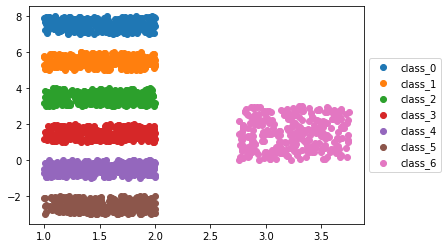

In [ ]:
for i in range(7):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("dist_4.png",bbox_inches="tight")
plt.savefig("dist_4.pdf",bbox_inches="tight")


In [ ]:
foreground_classes = {'class_0','class_1','class_2','class_3','class_4','class_5',}

background_classes = {'class_6'}

In [ ]:
fg_class  = np.random.randint(0,6)
fg_idx = np.random.randint(0,9) #m=2

a = []
for i in range(9): #m=2
    if i == fg_idx:
        b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
        a.append(x[b])
        print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
        bg_class = np.random.randint(6,7)
        b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
        a.append(x[b])
        print("background "+str(bg_class)+" present at " + str(i))
a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 6 present at 0
background 6 present at 1
background 6 present at 2
background 6 present at 3
background 6 present at 4
background 6 present at 5
foreground 4 present at 6
background 6 present at 7
background 6 present at 8
(9, 8)
4 6


In [ ]:
a.shape

(9, 8)

In [ ]:
desired_num = 3000
mosaic_list =[]
mosaic_label = []
fore_idx=[]
for j in range(desired_num):
    fg_class  = np.random.randint(0,6)
    fg_idx = np.random.randint(0,9) #m=2
    a = []
    for i in range(9):  #m=2
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(6,7)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list.append(np.reshape(a,(72,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

In [ ]:
mosaic_list = np.concatenate(mosaic_list,axis=1).T
# print(mosaic_list)

In [ ]:
print(np.shape(mosaic_label))
print(np.shape(fore_idx))

(3000,)
(3000,)


In [ ]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [ ]:
class Wherenet(nn.Module):
    def __init__(self):
        super(Wherenet,self).__init__()
        self.linear1 = nn.Linear(8,1)

    def forward(self,z):
        x = torch.zeros([batch,9],dtype=torch.float64)  #m=2
        y = torch.zeros([batch,8], dtype=torch.float64)  # 8-d data
        #x,y = x.to("cuda"),y.to("cuda")
        for i in range(9):  #m=9
          x[:,i] = self.helper(z[:,8*i:8*i+8])[:,0]
            #print(k[:,0].shape,x[:,i].shape)
        x = F.softmax(x,dim=1)   # alphas
        x1 = x[:,0]
        for i in range(9): #m=9
            x1 = x[:,i]          
            #print()
            y = y+torch.mul(x1[:,None],z[:,8*i:8*i+8])
        return y , x 

    
    def helper(self,x):
        #x = F.relu(self.linear1(x))
        #x = F.relu(self.linear2(x))
        x = self.linear1(x)
        return x

    

In [ ]:
trainiter = iter(train_loader)
input1,labels1,index1 = trainiter.next()



In [ ]:
where = Wherenet().double()
where = where
out_where,alphas = where(input1)
out_where.shape,alphas.shape

(torch.Size([250, 8]), torch.Size([250, 9]))

In [ ]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(8,6)
        #self.linear2 = nn.Linear(4,3)
#         self.linear3 = nn.Linear(8,3)
    def forward(self,x):
        #x = F.relu(self.linear1(x))
        #x = F.relu(self.linear2(x))
        x = self.linear1(x)
        return x

In [ ]:
what = Whatnet().double()
# what(out_where)

In [ ]:
test_data_required = 1000
mosaic_list_test =[]
mosaic_label_test = []
fore_idx_test=[]
for j in range(test_data_required):
    fg_class  = np.random.randint(0,6)
    fg_idx = np.random.randint(0,9)  #m=2
    a = []
    for i in range(9): #m=2
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(6,7)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_test.append(np.reshape(a,(72,1)))
    mosaic_label_test.append(fg_class)
    fore_idx_test.append(fg_idx)

In [ ]:
mosaic_list_test = np.concatenate(mosaic_list_test,axis=1).T
print(mosaic_list_test.shape)

(1000, 72)


In [ ]:
test_data = MosaicDataset(mosaic_list_test,mosaic_label_test,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [ ]:

focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]

criterion = nn.CrossEntropyLoss()
optimizer_where = optim.SGD(where.parameters(), lr=0.01)#,momentum=0.9)
optimizer_what = optim.SGD(what.parameters(), lr=0.01)#, momentum=0.9)

nos_epochs = 500

train_loss=[]
test_loss =[]
train_acc = []
test_acc = []
for epoch in range(nos_epochs):  # loop over the dataset multiple times

    focus_true_pred_true =0
    focus_false_pred_true =0
    focus_true_pred_false =0
    focus_false_pred_false =0

    argmax_more_than_half = 0
    argmax_less_than_half =0

    running_loss = 0.0
    cnt=0

    iteration = desired_num // batch

    #training data set

    for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        #inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device)
        # zero the parameter gradients

        optimizer_what.zero_grad()
        optimizer_where.zero_grad()
        
        
        avg_inp,alphas = where(inputs)
        
        outputs = what(avg_inp)
        
        _, predicted = torch.max(outputs.data, 1)
        
        loss = criterion(outputs, labels) 
        loss.backward() 
        
        optimizer_what.step()
        optimizer_where.step() 
        

        running_loss += loss.item()
        #if  ((1.0*running_loss)/6) <0.01:
         # break
        if cnt % 6 == 5:    # print every 6 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 6))
            running_loss = 0.0

        cnt=cnt+1
    
        if epoch % 5 == 4:
            for j in range (batch):
                focus = torch.argmax(alphas[j])

                if(alphas[j][focus] >= 0.5):
                    argmax_more_than_half +=1
                else:
                    argmax_less_than_half +=1

                if(focus == fore_idx[j] and predicted[j] == labels[j]):
                    focus_true_pred_true += 1

                elif(focus != fore_idx[j] and predicted[j] == labels[j]):
                    focus_false_pred_true +=1

                elif(focus == fore_idx[j] and predicted[j] != labels[j]):
                    focus_true_pred_false +=1

                elif(focus != fore_idx[j] and predicted[j] != labels[j]):
                    focus_false_pred_false +=1

    if epoch % 5 == 4:
        col1.append(epoch)
        col2.append(argmax_more_than_half)
        col3.append(argmax_less_than_half)
        col4.append(focus_true_pred_true)
        col5.append(focus_false_pred_true)
        col6.append(focus_true_pred_false)
        col7.append(focus_false_pred_false)

    #************************************************************************
        #testing data set  
        with torch.no_grad():
            focus_true_pred_true =0
            focus_false_pred_true =0
            focus_true_pred_false =0
            focus_false_pred_false =0

            argmax_more_than_half = 0
            argmax_less_than_half =0
            for data in test_loader:
                inputs, labels , fore_idx = data
                #inputs,labels,fore_idx = inputs.to(device),labels.to(device),fore_idx.to(device) 
#                 print(inputs.shtorch.save(where.state_dict(),"model_epoch"+str(epoch)+".pt")ape,labels.shape)
                avg_inp,alphas = where(inputs)
                outputs = what(avg_inp)
                _, predicted = torch.max(outputs.data, 1)

                for j in range (batch):
                    focus = torch.argmax(alphas[j])

                    if(alphas[j][focus] >= 0.5):
                        argmax_more_than_half +=1
                    else:
                        argmax_less_than_half +=1

                    if(focus == fore_idx[j] and predicted[j] == labels[j]):
                        focus_true_pred_true += 1

                    elif(focus != fore_idx[j] and predicted[j] == labels[j]):
                        focus_false_pred_true +=1

                    elif(focus == fore_idx[j] and predicted[j] != labels[j]):
                        focus_true_pred_false +=1

                    elif(focus != fore_idx[j] and predicted[j] != labels[j]):
                        focus_false_pred_false +=1

        col8.append(argmax_more_than_half)
        col9.append(argmax_less_than_half)
        col10.append(focus_true_pred_true)
        col11.append(focus_false_pred_true)
        col12.append(focus_true_pred_false)
        col13.append(focus_false_pred_false)
        
        #torch.save(where.state_dict(),"where_model_epoch"+str(epoch)+".pt")
        #torch.save(what.state_dict(),"what_model_epoch"+str(epoch)+".pt")
    
print('Finished Training')
#torch.save(where.state_dict(),"where_model_epoch"+str(nos_epochs)+".pt")
#torch.save(what.state_dict(),"what_model_epoch"+str(epoch)+".pt")


[1,     6] loss: 1.934
[1,    12] loss: 1.880
[2,     6] loss: 1.869
[2,    12] loss: 1.860
[3,     6] loss: 1.843
[3,    12] loss: 1.830
[4,     6] loss: 1.821
[4,    12] loss: 1.815
[5,     6] loss: 1.810
[5,    12] loss: 1.799
[6,     6] loss: 1.803
[6,    12] loss: 1.787
[7,     6] loss: 1.788
[7,    12] loss: 1.790
[8,     6] loss: 1.787
[8,    12] loss: 1.781
[9,     6] loss: 1.782
[9,    12] loss: 1.779
[10,     6] loss: 1.782
[10,    12] loss: 1.774
[11,     6] loss: 1.778
[11,    12] loss: 1.773
[12,     6] loss: 1.773
[12,    12] loss: 1.774
[13,     6] loss: 1.770
[13,    12] loss: 1.773
[14,     6] loss: 1.767
[14,    12] loss: 1.773
[15,     6] loss: 1.771
[15,    12] loss: 1.765
[16,     6] loss: 1.765
[16,    12] loss: 1.767
[17,     6] loss: 1.763
[17,    12] loss: 1.765
[18,     6] loss: 1.764
[18,    12] loss: 1.760
[19,     6] loss: 1.760
[19,    12] loss: 1.759
[20,     6] loss: 1.757
[20,    12] loss: 1.756
[21,     6] loss: 1.752
[21,    12] loss: 1.755
[22,     6

In [ ]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [ ]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,4,0,3000,0,902,0,2098
1,9,0,3000,0,730,0,2270
2,14,0,3000,0,669,0,2331
3,19,0,3000,0,831,21,2148
4,24,0,3000,430,475,498,1597
...,...,...,...,...,...,...,...
95,479,1697,1303,1782,406,755,57
96,484,1720,1280,1818,377,758,47
97,489,1744,1256,1864,338,759,39
98,494,1776,1224,1918,294,750,38


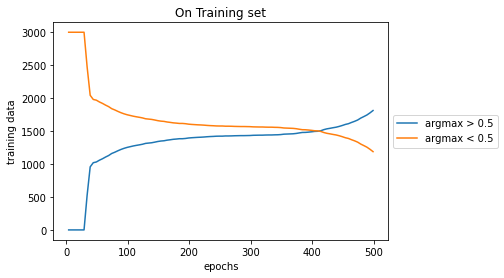

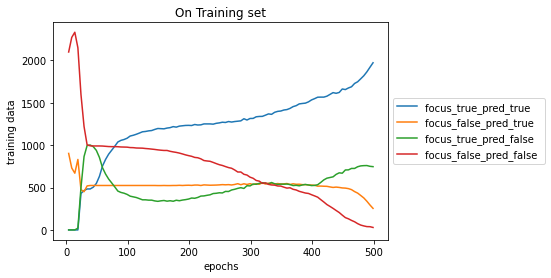

In [ ]:
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.savefig("dist_4_train.png",bbox_inches="tight")
plt.savefig("dist_4_train.pdf",bbox_inches="tight")
plt.show()

In [ ]:
df_test

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false
0,4,0,1000,0,278,0,722
1,9,0,1000,0,216,0,784
2,14,0,1000,0,189,0,811
3,19,0,1000,0,267,26,707
4,24,0,1000,140,145,184,531
...,...,...,...,...,...,...,...
95,479,565,435,597,146,243,14
96,484,571,429,615,134,239,12
97,489,580,420,632,121,239,8
98,494,586,414,649,106,238,7


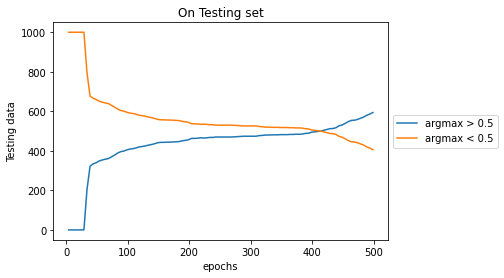

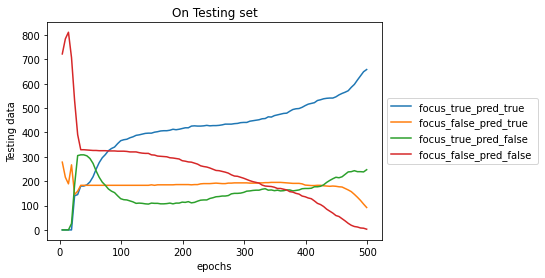

In [ ]:
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.savefig("dist_4_test.png",bbox_inches="tight")
plt.savefig("dist_4_test.pdf",bbox_inches="tight")
plt.show()

In [ ]:
# where.state_dict()["linear1.weight"][:]  = torch.Tensor(np.array([[ 0, -1]]))
# where.state_dict()["linear1.bias"][:] = torch.Tensor(np.array([0]))

In [ ]:
for param in where.named_parameters():
  print(param)

('linear1.weight', Parameter containing:
tensor([[-1.3579,  0.4067, -0.2029, -0.0777, -0.3421, -0.3126, -0.0272, -0.1855]],
       dtype=torch.float64, requires_grad=True))
('linear1.bias', Parameter containing:
tensor([-0.0408], dtype=torch.float64, requires_grad=True))


In [ ]:
# what.state_dict()["linear1.weight"][:]  = torch.Tensor(np.array([[ 5,  0],
#         [0,5],
#         [ 0, 0]]))
# what.state_dict()["linear1.bias"][:] = torch.Tensor(np.array([0,  0, 0]))

In [ ]:
for param in what.named_parameters():
  print(param)

('linear1.weight', Parameter containing:
tensor([[-2.9049,  1.8994, -0.0424,  0.1709, -0.3395,  0.0617, -0.1373, -0.1406],
        [-1.2169,  1.2625,  0.3327,  0.3584,  0.0424,  0.1279,  0.3495, -0.2506],
        [-0.2056,  0.5021, -0.0158, -0.0483, -0.3091, -0.2096, -0.2991,  0.1948],
        [ 1.0411, -0.5671,  0.1435, -0.2201, -0.0676, -0.0970,  0.2956, -0.1055],
        [ 1.5995, -1.5881,  0.1664,  0.0668, -0.1451,  0.3503, -0.1621, -0.0565],
        [ 1.8837, -1.4537,  0.2842, -0.1853,  0.1178, -0.2732,  0.0619, -0.1824]],
       dtype=torch.float64, requires_grad=True))
('linear1.bias', Parameter containing:
tensor([-1.0254, -0.2003,  0.6936,  0.3131,  0.2728, -0.4969],
       dtype=torch.float64, requires_grad=True))


In [ ]:
# xx,yy= np.meshgrid(np.arange(0.9,6.5,0.05),np.arange(-5.1,6.5,0.05))
# X = np.concatenate((xx.reshape(-1,1),yy.reshape(-1,1)),axis=1)
# X = torch.Tensor(X).double()
# Y = where.helper(X)
# Y1 = what(X)

In [ ]:
# X.shape,Y.shape

In [ ]:
# X = X.detach().numpy()
# Y = Y[:,0].detach().numpy()

In [ ]:
# fig = plt.figure(figsize=(6,6))
# cs = plt.contourf(X[:,0].reshape(xx.shape),X[:,1].reshape(yy.shape),Y.reshape(xx.shape))
# plt.xlabel("X1")
# plt.ylabel("X2")
# fig.colorbar(cs)
# for i in range(7):
#     plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
# #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig("dist_4_fc.png")#,bbox_inches='tight')
# plt.savefig("dist_4_fc.pdf")

In [ ]:
# Y1 = Y1.detach().numpy()
# Y1 = torch.softmax(torch.Tensor(Y1),dim=1)
# _,Z4= torch.max(Y1,1)
# Z1 = Y1[:,0]
# Z2 = Y1[:,1]
# #Z3 = Y1[:,2]

In [ ]:
# np.unique(Z4)

In [ ]:
#fig = plt.figure(figsize=(6,6))
# plt.scatter(X[:,0],X[:,1],c=Z1)
# plt.scatter(X[:,0],X[:,1],c=Z2)
# plt.scatter(X[:,0],X[:,1],c=Z3)
#cs = plt.contourf(X[:,0].reshape(xx.shape),X[:,1].reshape(yy.shape),Z1.reshape(xx.shape))
# #plt.colorbar(cs)
# cs = plt.contourf(X[:,0].reshape(xx.shape),X[:,1].reshape(yy.shape),Z2.reshape(xx.shape))
# #plt.colorbar(cs)
# cs = plt.contourf(X[:,0].reshape(xx.shape),X[:,1].reshape(yy.shape),Z3.reshape(xx.shape))
#plt.colorbar(cs)
# plt.xlabel("X1")
# plt.ylabel("X2")
#ax.view_init(60,100)
#plt.savefig("non_interpretable_class_2d.pdf",bbox_inches='tight')


In [ ]:
avrg = []
lbl = []
with torch.no_grad():
  for i, data in  enumerate(train_loader):
          inputs , labels , fore_idx = data
          avg_inp,alphas = where(inputs)
          avrg.append(avg_inp)
          lbl.append(labels.numpy())
avrg= np.concatenate(avrg,axis=0)
lbl = np.concatenate(lbl,axis=0)

In [ ]:
indices = []
for i in range(6):
    print(i,sum(lbl==i))
    indices.append(lbl==i)

0 483
1 536
2 457
3 505
4 495
5 524


In [ ]:
avrg[indices[4],:][0]

array([2.91861884e+00, 1.10274218e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.23717990e-04, 0.00000000e+00])

In [ ]:
true = []
pred = []
acc= 0
for i, data in  enumerate(train_loader):
        inputs , labels , fore_idx = data
        avg_inp,alphas = where(inputs)
        outputs = what(avg_inp)
        _, predicted = torch.max(outputs.data, 1)
        true.append(labels)
        pred.append(predicted)
        acc+=sum(predicted == labels)

In [ ]:
true = np.concatenate(true,axis=0)
pred = np.concatenate(pred,axis=0)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(true,pred)

array([[453,  30,   0,   0,   0,   0],
       [149, 385,   2,   0,   0,   0],
       [  0,  62, 381,  14,   0,   0],
       [  0,   0,  41, 391,   1,  72],
       [  0,   0,   0,   5, 134, 356],
       [  0,   0,   0,   6,  37, 481]])

In [ ]:
sum(true==pred)

2225

In [ ]:
a = [1,2,3]
b = [4,5,6]

In [ ]:
list(np.append(a,b))

[1, 2, 3, 4, 5, 6]

In [ ]:
a

[1, 2, 3]